### Aula 02 - parte b - Realce utilizando histogramas

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Ao invés de operar unicamente a partir do valor de um pixel, podemos obter mais informações sobre a imagem de forma a tomar decisões sobre realce. Uma técnica comumente empregada é o *histograma*, que fornece estatística sobre a frequência das intensidades presentes na imagem. O histograma é obtido contando quantas vezes cada intensidade aparece na imagem


In [40]:
# randint permite criar rrays com números aleatorios inteiros
# abaixo, uma matriz 10x10 com valores entre 0 e 7
A = np.random.randint(0,8,[5,5])
print(A)

[[2 3 7 6 0]
 [6 1 4 7 5]
 [1 5 0 2 3]
 [2 0 2 2 5]
 [7 2 1 6 1]]


Ainda que de forma nao otimizada, uma maneira simples de obter o histograma seria, sabendo o intervalo de valores possiveis na imagem, percorrendo todos os pixels. Vamos criar uma função em python que calcule e retorne o histograma


In [56]:
def histogram(A, nbins):
    # obtem o tamanho da matriz
    N, M = A.shape
    # cria histograma vazio, com 'nbins' posicoes
    hist = np.zeros(nbins).astype(int)

    #percorre imagem, contando valores
    for x in range(N):
        for y in range(M):
            hist[A[x,y]] += 1 # incrementa histograma no valor A[x,y]
            
    return(hist)

Agora podemos utilizar essa função, chamando-a para a matriz, passando a quantidade de valores do histograma (também chamados de *bins*) e posteriormente imprimindo o histograma calculado

In [57]:
hist_A = histogram(A, 8)
print(hist_A)

[3 4 6 2 1 3 3 3]


O histograma é comumente exibido por meio de um gráfico de barras. Utilizaremos a função `plt.bar`, que recebe o intervalo e as contagens para exibir os valores

Text(0,0.5,'Frequencia')

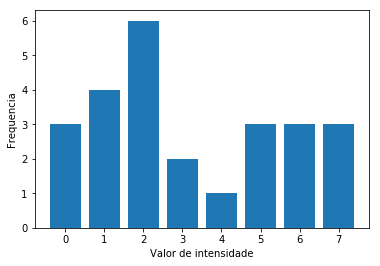

In [58]:
plt.bar(range(8), hist_A)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')

Agora vamos calcular o histograma para duas imagens, e exibir os gráficos, da mesma forma que fizemos anteriormente para a matriz. Note a distribuição dos tons de cinza de acordo com sa características de brilho e contraste das imagens.

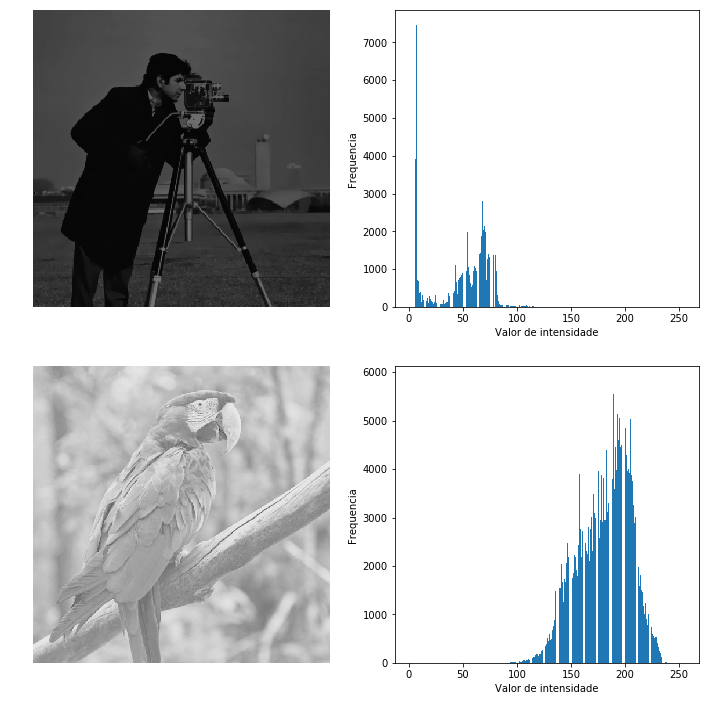

In [103]:
img1 = imageio.imread("imagens/cameraman.png")
img2 = imageio.imread("imagens/arara.jpg")

# calculamos o histograma considerando a contagem de 256 valores (tons de cinza)
hist_img1 = histogram(img1, 256)
hist_img2 = histogram(img2, 256)

# exibindo imagens e histogramas (note que uso vmin, vmax para exibir todo o intervalo de tons de cinza)
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(223)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(222)
plt.bar(range(256), hist_img1)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')

plt.subplot(224)
plt.bar(range(256), hist_img2)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')
plt.show()

A imagem da esquerda, *Cameraman* possui predominância de tons escuros, enquanto a imagem da direita, *Scarlett* possui muitos pixels de intensidade mais clara. Assim, o histograma oferece a informação da distribuição dos tons de cinza na imagem.

*Podemos usar essa informação como base para criar uma transformação obtida diretamente a partir dos dados da imagem*

Esse tipo de transformação é conhecida como **Equalização de Histograma**.

A equalização de histograma utiliza o histograma acumulado para obter uma função de transferência (ou de transformação) para realce da imagem. Note que não estamos projetando manualmente a transformação de realce, mas sim computando diretamente a partir dos dados (um tipo de "*data-driven enhancement*")

Para isso primeiramente obtemos o histograma cumulativo, e depois escalamos esse histograma cumulativo de forma a obter uma transformação que nos leve do intervalo original de tons de cinza (e.g. 0-255), para o mesmo intervalo (veja mais detalhes sobre isso no Notebook anterior "02a_enhancement_pixel")

A transformação, para cada valor de pixel *r* é dada por: $$s = T(r) = \frac{L-1}{MN} hc(r)$$ onde *hc* é o histograma cumulativo, e *hc(r)* é o valor do histograma cumulativo para a intensidade *r*

In [104]:
def histogram_equalization(A, values):
    # obtem histograma em matriz com total de valores dado por 'values'
    hist = histogram(A, values)
    
    # cria histograma cumulativo vazio, do mesmo tamanho do histograma 
    histC = np.zeros(hist.shape).astype(int)

    # calcula histograma cumulativo
    histC[0] = hist[0]
    for i in range(1, values):
        histC[i] = hist[i] + histC[i-1]

    # tamanho da imagem/matriz    
    N, M = A.shape
    
    # o vetor abaixo e usado para guardar a funcao de transformacao, 
    # apenas para propositos didaticos (iremos visualizar posteriormente)
    hist_transform = np.zeros(values).astype(np.uint8)
    
    # nova imagem equalizada
    A_eq = np.zeros(A.shape).astype(np.uint8)
    
    # transforma as intensidades de 'A' usando histC como funcao de transferencia
    # para cada tom de cinza
    for r in range(values):
        # computa qual seria o novo valor 's', dado o valor atual 'r' 
        s = ((values-1)/float(M*N))*histC[r]
        
        # em toda posicao de "A" que existir um valor 'r', 
        # entao na nova imagem esse pixel sera 's'
        A_eq[ np.where(A == r) ] = s
        
        # guardamos a transformacao
        hist_transform[r] = s
    
    return (A_eq, hist_transform)

Equalizando as imagens. Repare que a equalizacao de histograma tenta deixar o histograma mais proximo do uniformemente distribuido.

In [117]:
img1_eq, img1_transf = histogram_equalization(img1, values=256)
img2_eq, img2_transf = histogram_equalization(img2, values=256)


Text(0,0.5,'Frequencia')

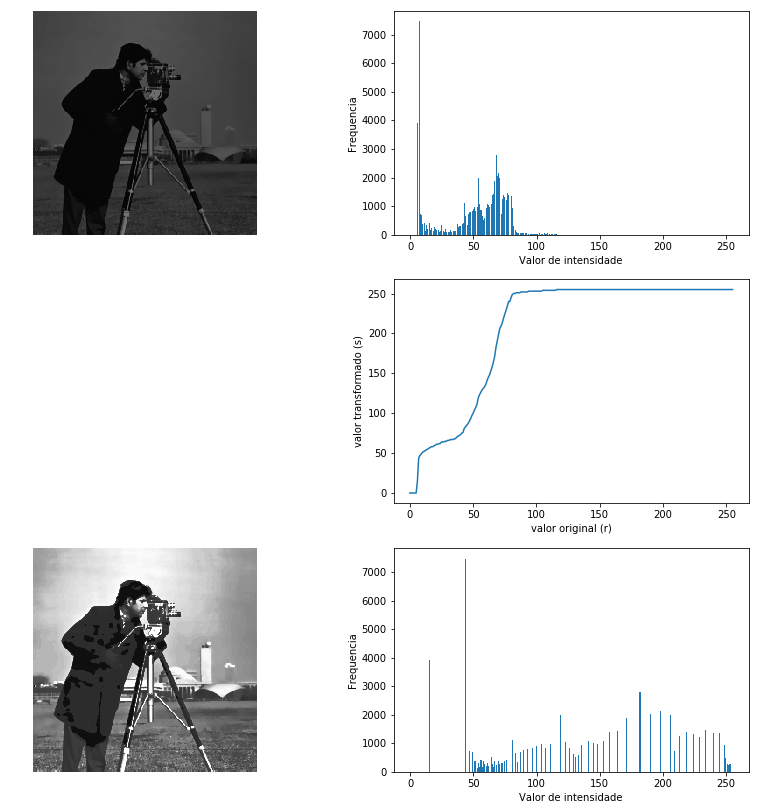

In [118]:
# novos histogramas
histeq_img1 = histogram(img1_eq, 256)
histeq_img2 = histogram(img2_eq, 256)

# exibindo imagens, histogramas e transformacoes

# imagem Cameraman
plt.figure(figsize=(14,14)) 
plt.subplot(3,2,1)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(3,2,2)
plt.bar(range(256), hist_img1)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')
plt.subplot(3,2,4)
plt.plot(range(256), img1_transf)
plt.xlabel('valor original (r)')
plt.ylabel('valor transformado (s)')

plt.subplot(3,2,5)
plt.imshow(img1_eq, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(3,2,6)
plt.bar(range(256), histeq_img1)
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')


Text(0,0.5,'Frequencia')

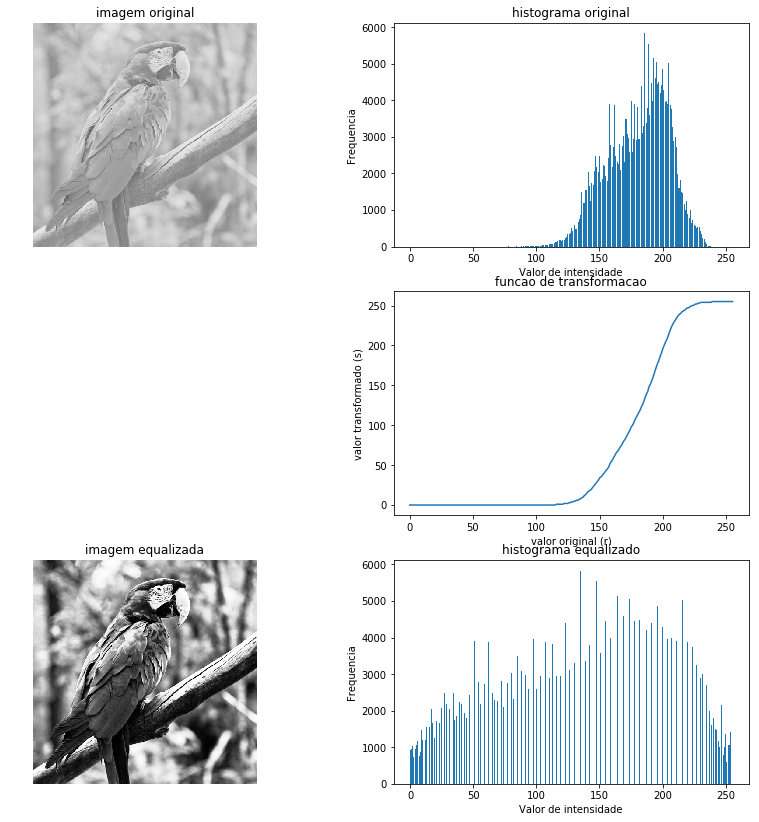

In [120]:

# imagem Arara
plt.figure(figsize=(14,14)) 

plt.subplot(3,2,1)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.title('imagem original')
plt.axis('off')
plt.subplot(3,2,2)
plt.bar(range(256), hist_img2)
plt.title('histograma original')
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')
plt.subplot(3,2,4)
plt.plot(range(256), img2_transf)
plt.title('funcao de transformacao')
plt.xlabel('valor original (r)')
plt.ylabel('valor transformado (s)')

plt.subplot(3,2,5)
plt.imshow(img2_eq, cmap="gray", vmin=0, vmax=255)
plt.title('imagem equalizada')
plt.axis('off')
plt.subplot(3,2,6)
plt.bar(range(256), histeq_img2)
plt.title('histograma equalizado')
plt.xlabel('Valor de intensidade')
plt.ylabel('Frequencia')